# Non Parametric Models & Ensemble Models
- Non Parametric Models
    - gbm
    - xgboost
- Ensemble Models (Param + Non param)

In [1]:
# -*-coding:utf-8 -*-
import pandas as pd
from os import path
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
import warnings
import numpy as np
from random import seed, randrange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#LOAD DATA
set_ver = 1
curdir = path.curdir
train_X_file = path.join(curdir, "cache/tr_X_{}.csv.gz".format(set_ver))
test_y_file = path.join(curdir, "cache/tr_y_{}.csv.gz".format(set_ver))
test_X_file = path.join(curdir, "cache/te_X_{}.csv.gz".format(set_ver))

tr_X = pd.read_csv(train_X_file, compression="gzip", index_col="Id")
tr_y = pd.read_csv(test_y_file, compression="gzip", index_col="Id")
te_X = pd.read_csv(test_X_file, compression="gzip", index_col="Id")

print(tr_X.shape, tr_y.shape, te_X.shape)

(1460, 247) (1460, 1) (1459, 247)


In [3]:
#SPLIT CROSS VALIDATION SET
seed(1000)
cv_ref = pd.DataFrame({'Id': tr_X.index})
cv_ref.loc[:, "cv"] = [randrange(5) for i in range(len(tr_X))]
cv_ref.groupby("cv").count()

,Id
cv,
0,290
1,297
2,295
3,297
4,281


## Non-parametric Models

In [4]:
min_log_saleprice = tr_y.SalePrice.min()
def root_mean_squared_error(y, pred_y):
    assert len(y) == len(pred_y)
    return np.sqrt(sum((pred_y - y)**2.0)/len(y))

def cross_validate(regr, X, y, cv_ref, validation_func, threshold = min_log_saleprice):
    scores = []
    for i in cv_ref.cv.unique():
        regr.fit(X[(cv_ref.cv != i).values], y[(cv_ref.cv != i).values])
        pred_y = regr.predict(X[(cv_ref.cv == i).values])
        # make it 0 for negative predictions
        pred_y[pred_y < threshold] = threshold 
        
        scores.append(
            validation_func(
                y[(cv_ref.cv == i).values].values.reshape(pred_y.shape[0]), 
                pred_y.reshape(pred_y.shape[0])))
    return scores

### Gradient Boosting Machine

In [7]:
regr = GradientBoostingRegressor()
cv_scores = cross_validate(
        regr, tr_X, tr_y.SalePrice, cv_ref, root_mean_squared_error)
print(np.mean(cv_scores))

0.132735152216


In [8]:
def gbm_n_estim_tuning(iterable_range, X, y, cv_table, validation_func, 
                 threshold=min_log_saleprice):
    rmsle = []
    best_param = 0 
    best_score = 1
    for i in iterable_range:
        regr = GradientBoostingRegressor(n_estimators=i)
        cv_scores = cross_validate(
            regr, X, y, cv_table, validation_func, threshold)
        mean_cv_score = np.mean(cv_scores)
        rmsle.append(mean_cv_score)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_param = i
        print("i: {} -> rmsle: {}".format(i, mean_cv_score))
    print("best score: {} at {}".format(best_score, best_param))
    plt.plot(iterable_range, rmsle)
    plt.title("Optimal param")
    plt.xlabel("param")
    plt.ylabel("RMSLE")

i: 100 -> rmsle: 0.13155188455147035
i: 130 -> rmsle: 0.13093658289367588
i: 160 -> rmsle: 0.13107050729641478
i: 190 -> rmsle: 0.13101996406074534
i: 220 -> rmsle: 0.13085573064486772
i: 250 -> rmsle: 0.1306735939388259
i: 280 -> rmsle: 0.13238457932032327
best score: 0.1306735939388259 at 250


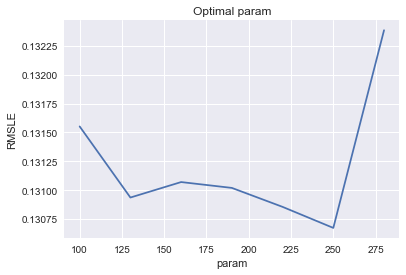

In [12]:
gbm_n_estim_tuning(range(100, 300, 30), tr_X, tr_y.SalePrice, cv_ref, root_mean_squared_error)

### XGBOOST

In [24]:
def cross_validate_xgb(params, X, y, cv_ref, validation_func, threshold = min_log_saleprice):
    scores = []
    for i in cv_ref.cv.unique():
        bst = xgb.train(params, 
                        xgb.DMatrix(X[(cv_ref.cv != i).values], 
                                    label=y[(cv_ref.cv != i).values]))
        pred_y = bst.predict(xgb.DMatrix(X[(cv_ref.cv == i).values]))
        # make it 0 for negative predictions
        pred_y[pred_y < threshold] = threshold 
        #plt.hist(pred_y)      
        scores.append(
            validation_func(y[(cv_ref.cv == i).values].values.reshape(pred_y.shape[0]), 
                            pred_y))
    return scores

In [29]:
param = {'objective' : 'reg:linear',
          'eta':1,
          'max_depth':6,
          'min_child_weight':1,
          'alpha':0,
          'lambda':0,
          'gamma':0}
param['nthread'] = 4

i: 0.0 -> rmsle: 1.614142523593062
i: 0.02 -> rmsle: 1.614142523593062
i: 0.04 -> rmsle: 1.614142523593062
i: 0.06 -> rmsle: 1.614142523593062
i: 0.08 -> rmsle: 1.614142523593062
i: 0.1 -> rmsle: 1.614142523593062
i: 0.12 -> rmsle: 1.614142523593062
i: 0.14 -> rmsle: 1.614142523593062
i: 0.16 -> rmsle: 1.5959142155633665
i: 0.18 -> rmsle: 1.4716185632342964
i: 0.2 -> rmsle: 1.2286788737514514
i: 0.22 -> rmsle: 0.9684071758347702
i: 0.24 -> rmsle: 0.7525930980198374
i: 0.26 -> rmsle: 0.5831464483241595
i: 0.28 -> rmsle: 0.4547378106239465
i: 0.3 -> rmsle: 0.3563191383966594
i: 0.32 -> rmsle: 0.28581126144880353
i: 0.34 -> rmsle: 0.23357558633214576
i: 0.36 -> rmsle: 0.1974925635960307
i: 0.38 -> rmsle: 0.17787952041021637
i: 0.4 -> rmsle: 0.16532107343580138
i: 0.42 -> rmsle: 0.15564591256237167
i: 0.44 -> rmsle: 0.1524831392583394
i: 0.46 -> rmsle: 0.1525010456771328
i: 0.48 -> rmsle: 0.15341465095140439
i: 0.5 -> rmsle: 0.15395272354546538
i: 0.52 -> rmsle: 0.15189357822927943
i: 0.54

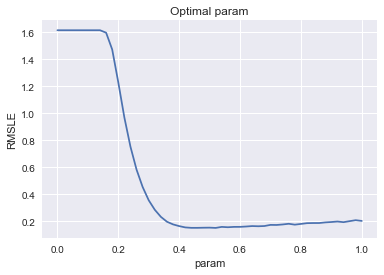

In [30]:
#tuning eta
iterable_range = np.linspace(0, 1, 51)
rmsle = []
best_param = 0 
best_score = 1

for i in iterable_range:
    param['eta'] = i
    cv_scores = cross_validate_xgb(
        param, tr_X, tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

i: 1 -> rmsle: 0.19290924810446675
i: 2 -> rmsle: 0.16155184183473356
i: 3 -> rmsle: 0.15015670342877016
i: 4 -> rmsle: 0.14724676295793823
i: 5 -> rmsle: 0.15578592165496583
i: 6 -> rmsle: 0.15189357822927943
i: 7 -> rmsle: 0.1541931225536927
i: 8 -> rmsle: 0.15687245653271156
i: 9 -> rmsle: 0.16547496937797246
i: 10 -> rmsle: 0.1683296594602056
i: 11 -> rmsle: 0.17348400406752712
i: 12 -> rmsle: 0.18241864165931237
i: 13 -> rmsle: 0.1892783527574482
i: 14 -> rmsle: 0.19192977669118194
best score: 0.14724676295793823 at 4


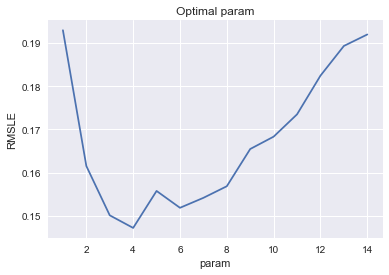

In [31]:
param['eta'] = 0.52
#tuning max depth
iterable_range = range(1, 15)
rmsle = []
best_param = 0 
best_score = 1

for i in iterable_range:
    param['max_depth'] = i
    cv_scores = cross_validate_xgb(
        param, tr_X, tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

i: 1.0 -> rmsle: 0.15567822568402026
i: 1.95 -> rmsle: 0.15563387857430072
i: 2.9 -> rmsle: 0.15739274368561246
i: 3.8499999999999996 -> rmsle: 0.16076175152772507
i: 4.8 -> rmsle: 0.17435449390162283
i: 5.75 -> rmsle: 0.17159226551830026
i: 6.699999999999999 -> rmsle: 0.17556768207990286
i: 7.6499999999999995 -> rmsle: 0.17569148374053623
i: 8.6 -> rmsle: 0.17670659377747608
i: 9.549999999999999 -> rmsle: 0.17392966995041004
i: 10.5 -> rmsle: 0.16589054528832703
i: 11.45 -> rmsle: 0.17053078568423402
i: 12.399999999999999 -> rmsle: 0.1740266493320112
i: 13.35 -> rmsle: 0.17558631367479574
i: 14.299999999999999 -> rmsle: 0.17715031696617417
i: 15.25 -> rmsle: 0.17650418966327192
i: 16.2 -> rmsle: 0.17884666504411964
i: 17.15 -> rmsle: 0.1791893163179441
i: 18.099999999999998 -> rmsle: 0.18248152134541265
i: 19.05 -> rmsle: 0.18298880298969572
i: 20.0 -> rmsle: 0.18447777537840784
best score: 0.15563387857430072 at 1.95


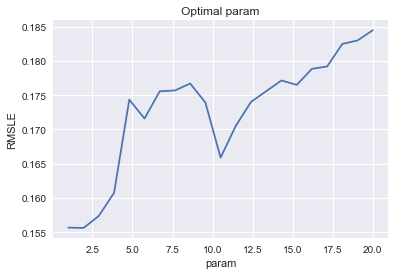

In [33]:
param['eta'] = 0.52
param['max_depth']  = 4
#tuning lambda
iterable_range = np.linspace(1, 20, 21)
rmsle = []
best_param = 0 
best_score = 1

for i in iterable_range:
    param['lambda'] = i
    cv_scores = cross_validate_xgb(
        param, tr_X, tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

i: 0.0 -> rmsle: 0.15563387857430072
i: 0.1 -> rmsle: 0.1563139439964209
i: 0.2 -> rmsle: 0.15293203182311052
i: 0.30000000000000004 -> rmsle: 0.15510020987219963
i: 0.4 -> rmsle: 0.15479651741944842
i: 0.5 -> rmsle: 0.15883737764235217
i: 0.6000000000000001 -> rmsle: 0.15999522297161636
i: 0.7000000000000001 -> rmsle: 0.16374418831311177
i: 0.8 -> rmsle: 0.16308883636338306
i: 0.9 -> rmsle: 0.1673187007261076
i: 1.0 -> rmsle: 0.1660476941003407
i: 1.1 -> rmsle: 0.16998423698255716
i: 1.2000000000000002 -> rmsle: 0.17449198605090155
i: 1.3 -> rmsle: 0.17601678873556587
i: 1.4000000000000001 -> rmsle: 0.17506775451473736
i: 1.5 -> rmsle: 0.17957740507089687
i: 1.6 -> rmsle: 0.1804488466307146
i: 1.7000000000000002 -> rmsle: 0.18209856083297243
i: 1.8 -> rmsle: 0.1825689129345733
i: 1.9000000000000001 -> rmsle: 0.1844091522205077
i: 2.0 -> rmsle: 0.18586233207034814
i: 2.1 -> rmsle: 0.1884562087007508
i: 2.2 -> rmsle: 0.18852959907893602
i: 2.3000000000000003 -> rmsle: 0.1882031108955761

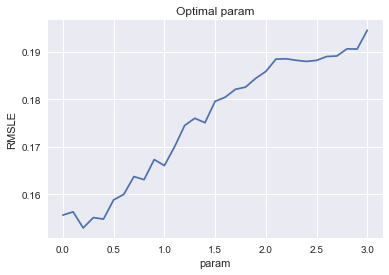

In [35]:
param['eta'] = 0.52
param['max_depth']  = 4
param['lambda'] = 1.95
#tuning gamma
iterable_range = np.linspace(0, 3, 31)
rmsle = []
best_param = 0 
best_score = 1

for i in iterable_range:
    param['gamma'] = i
    cv_scores = cross_validate_xgb(
        param, tr_X, tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

i: 0.0 -> rmsle: 0.15293203182311052
i: 0.1 -> rmsle: 0.15341395432092875
i: 0.2 -> rmsle: 0.1548693844164394
i: 0.30000000000000004 -> rmsle: 0.15894623025627652
i: 0.4 -> rmsle: 0.15830964028481728
i: 0.5 -> rmsle: 0.16008809588720613
i: 0.6000000000000001 -> rmsle: 0.15790603891262198
i: 0.7000000000000001 -> rmsle: 0.16071147969284716
i: 0.8 -> rmsle: 0.16156165093552263
i: 0.9 -> rmsle: 0.1632409862084599
i: 1.0 -> rmsle: 0.16484691384272057
i: 1.1 -> rmsle: 0.16627702746811251
i: 1.2000000000000002 -> rmsle: 0.16509288664240535
i: 1.3 -> rmsle: 0.16289303837280894
i: 1.4000000000000001 -> rmsle: 0.16482752672722772
i: 1.5 -> rmsle: 0.16154592042560803
i: 1.6 -> rmsle: 0.16356181736444175
i: 1.7000000000000002 -> rmsle: 0.16308174090185307
i: 1.8 -> rmsle: 0.16445518508311865
i: 1.9000000000000001 -> rmsle: 0.16580475680796794
i: 2.0 -> rmsle: 0.16285755704152693
i: 2.1 -> rmsle: 0.16515045109927515
i: 2.2 -> rmsle: 0.1688279567325969
i: 2.3000000000000003 -> rmsle: 0.170448517481

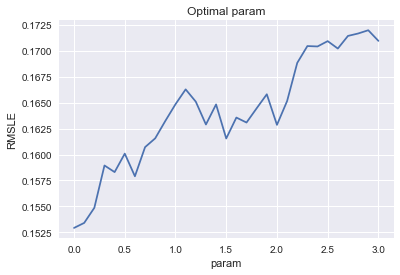

In [44]:
param['eta'] = 0.52
param['max_depth']  = 4
param['lambda'] = 1.95
param['gamma'] = 0.2
#tuning alpha
iterable_range = np.linspace(0, 3, 31)
rmsle = []
best_param = 0 
best_score = 1

for i in iterable_range:
    param['alpha'] = i
    cv_scores = cross_validate_xgb(
        param, tr_X, tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

### ENSEMBLE (GRADIENT BOOST + RIDGE + LASSO)

In [42]:
feature_selected = ['LotFrontage',
 'OverallQual',
 'YearRemodAdd',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'KitchenQual',
 'FireplaceQu',
 'GarageCars',
 'WoodDeckSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'hasWoodDeck',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'LotShape_nan',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'Neighborhood_Etc',
 'Neighborhood_Gilbert',
 'Neighborhood_NWAmes',
 'Neighborhood_StoneBr',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosN',
 'Condition1_RRAn',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_nan',
 'BldgType_2fmCon',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'HouseStyle_nan',
 'RoofStyle_Hip',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_WdShake',
 'RoofMatl_nan',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_HdBoard',
 'Exterior1st_Plywood',
 'Exterior1st_Wd Sdng',
 'Exterior2nd_AsphShn',
 'Exterior2nd_CBlock',
 'Exterior2nd_HdBoard',
 'Exterior2nd_Plywood',
 'Exterior2nd_Wd Sdng',
 'MasVnrType_Stone',
 'Foundation_CBlock',
 'Foundation_nan',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_nan',
 'CentralAir_Y',
 'Electrical_Mix',
 'Electrical_nan',
 'Functional_Maj2',
 'Functional_Mod',
 'Functional_Typ',
 'GarageType_Attchd',
 'GarageType_BuiltIn',
 'GarageType_Detchd',
 'GarageFinish_Unf',
 'PavedDrive_Y',
 'Fence_GdWo',
 'MiscFeature_Shed',
 'MiscFeature_nan',
 'MoSold_11',
 'MoSold_5',
 'SaleCondition_AdjLand',
 'SaleCondition_Normal',
 'MSSubClass_age_NEWER',
 'MSSubClass_finish_FIN',
 'MSSubClass_finish_PUD',
 'MSSubClass_finish_nan',
 'LotArea',
 'MoSold_6',
 'MoSold_7',
 'hasEnclPorch',
 'Neighborhood_Somerst']

def bring_interaction(X, level=2):
    '''
    level: int >=2
    X
    
    returns: X with polynomial features
    '''
    
    poly = PolynomialFeatures(level)
    Xpoly = poly.fit_transform(X)
    
    return Xpoly

tr_X_poly = bring_interaction(tr_X.loc[:, feature_selected])
te_X_poly = bring_interaction(te_X.loc[:, feature_selected])

In [80]:
def cross_validate_mix(regr_list, X, X_poly, y, cv_table, 
                       validation_func, threshold = min_log_saleprice):
    scores = [] 
    for i in range(5):
        pred_y_list = []
        #print(i)
        real_y = y[(cv_table.cv == i).values]
        if "ridge" in regr_list:
            regr = Ridge(alpha=23)
            regr.fit(X_poly[(cv_table.cv != i).values], y[(cv_table.cv != i).values])
            pred_y_list.append(regr.predict(X_poly[(cv_table.cv == i).values])) 
            
        if "lasso" in regr_list:
            regr2 = Lasso(alpha=0.001)
            regr2.fit(X_poly[(cv_table.cv != i).values], y[(cv_table.cv != i).values])
            pred_y_list.append(regr2.predict(X_poly[(cv_table.cv == i).values])) 
            
        if "gbm" in regr_list:
            regr3 = GradientBoostingRegressor(n_estimators=250)
            regr3.fit(X[(cv_table.cv != i).values], y[(cv_table.cv != i).values])
            pred_y_list.append(regr3.predict(X[(cv_table.cv == i).values])) 

        if "xgb" in regr_list: 
            xgb_param = {'alpha': 0,
                         'eta': 0.52,
                         'gamma': 0.2,
                         'lambda': 1.95,
                         'max_depth': 14,
                         'min_child_weight': 1,
                         'nthread': 4,
                         'objective': 'reg:linear'}
            bst = xgb.train(xgb_param, 
                        xgb.DMatrix(X[(cv_table.cv != i).values], 
                                    label=y[(cv_table.cv != i).values]))
            pred_y_list.append(bst.predict(xgb.DMatrix(X[(cv_table.cv == i).values])))
        
        pred_y = pd.Series(0.0, index=range(len(pred_y_list[0])))
        n = len(pred_y_list)
        
        for i in range(pred_y.shape[0]):
            for model_n in range(len(pred_y_list)):
                pred_y[i] += pred_y_list[model_n][i]
            pred_y[i] = pred_y[i]/float(n)
        # make it 0 for negative predictions
        pred_y[pred_y < threshold] = threshold 
        score = validation_func(real_y.values.reshape(pred_y.shape[0]), 
                                pred_y.values.reshape(pred_y.shape[0]))
        scores.append(score)
    return scores

In [81]:
regr_list = ["ridge","lasso","gbm","xgb"]
for i in range(2,5):
    for comb in combinations(regr_list, i): 
        cv_scores = cross_validate_mix(list(comb), 
                       tr_X, tr_X_poly, tr_y.SalePrice, cv_ref, root_mean_squared_error)
        print(comb, np.mean(cv_scores))

('ridge', 'lasso') 0.14112413048
('ridge', 'gbm') 0.127453315127
('ridge', 'xgb') 0.133408862894
('lasso', 'gbm') 0.129911826981
('lasso', 'xgb') 0.136418394907
('gbm', 'xgb') 0.13409793776
('ridge', 'lasso', 'gbm') 0.130690249204
('ridge', 'lasso', 'xgb') 0.133253694087
('ridge', 'gbm', 'xgb') 0.127855307079
('lasso', 'gbm', 'xgb') 0.129778606286
('ridge', 'lasso', 'gbm', 'xgb') 0.128683205601


i: 10.0 -> rmsle: 0.12882847777686748
i: 10.2 -> rmsle: 0.12866995604432652
i: 10.4 -> rmsle: 0.12880962900409137
i: 10.6 -> rmsle: 0.12871667408997806
i: 10.8 -> rmsle: 0.12877050530588394
i: 11.0 -> rmsle: 0.12921682186137573
i: 11.2 -> rmsle: 0.1304968628753771
i: 11.4 -> rmsle: 0.1359258424691759
i: 11.6 -> rmsle: 0.1530121310664017
i: 11.8 -> rmsle: 0.19492947655489554
i: 12.0 -> rmsle: 0.2746302173697907
best score: 0.12866995604432652 at 10.2


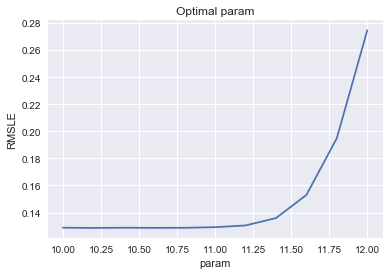

In [86]:
#tuning threshold
regr_list = ["ridge","lasso","gbm","xgb"]
iterable_range=np.linspace(10, 12, 11)
rmsle = []
best_param = 0 
best_score = 1
for i in iterable_range: 
    cv_scores = cross_validate_mix(regr_list, 
                       tr_X, tr_X_poly, tr_y.SalePrice, cv_ref, root_mean_squared_error, i)
    mean_cv_score = np.mean(cv_scores)
    rmsle.append(mean_cv_score)
    if mean_cv_score < best_score:
        best_score = mean_cv_score
        best_param = i
    print("i: {} -> rmsle: {}".format(i, mean_cv_score))
print("best score: {} at {}".format(best_score, best_param))
plt.plot(iterable_range, rmsle)
plt.title("Optimal param")
plt.xlabel("param")
plt.ylabel("RMSLE")

In [87]:
def predict_mix(regr_list, train_X, train_X_poly, train_y, cv_ref, test_X, test_X_poly):
    pred_y_list = {}
 
    if "ridge" in regr_list:
        regr = Ridge(alpha=23)
        regr.fit(train_X_poly, train_y)
        pred_y_list["ridge"]=regr.predict(test_X_poly)

    if "lasso" in regr_list:
        regr2 = Lasso(alpha=0.001)
        regr2.fit(train_X_poly, train_y)
        pred_y_list["lasso"]=regr2.predict(test_X_poly) 

    if "gbm" in regr_list:
        regr3 = GradientBoostingRegressor(n_estimators=250)
        regr3.fit(train_X, train_y)
        pred_y_list["gbm"]=regr3.predict(test_X) 

    if "xgb" in regr_list: 
        xgb_param = {'alpha': 0,
                     'eta': 0.52,
                     'gamma': 0.2,
                     'lambda': 1.95,
                     'max_depth': 14,
                     'min_child_weight': 1,
                     'nthread': 4,
                     'objective': 'reg:linear'}
        bst = xgb.train(xgb_param, 
                    xgb.DMatrix(train_X, 
                                label=train_y))
        pred_y_list["xgb"] = bst.predict(xgb.DMatrix(test_X))

    return pred_y_list

In [89]:
pred_y_list = predict_mix(
    regr_list, tr_X, tr_X_poly, tr_y.SalePrice, cv_ref, te_X, te_X_poly)

In [90]:
df = pd.DataFrame(pred_y_list)
df.head()

,gbm,lasso,ridge,xgb
0,11.689614,11.603402,11.636926,11.739869
1,11.995332,11.990967,12.037584,11.971425
2,12.145299,12.077324,12.082653,12.110606
3,12.131338,12.205242,12.195773,12.147421
4,12.164562,12.202075,12.165037,12.147438


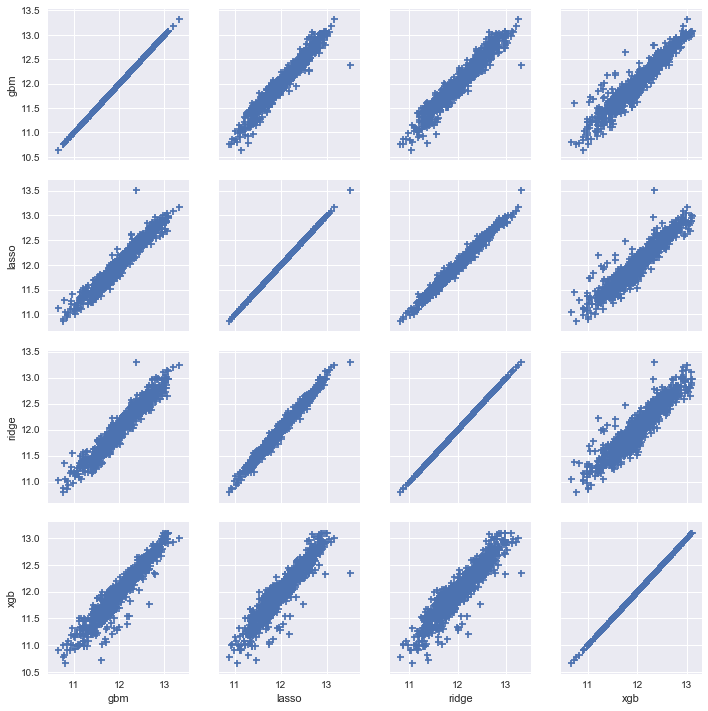

In [91]:
g = sns.PairGrid(df)
g = g.map(plt.scatter, marker="+")

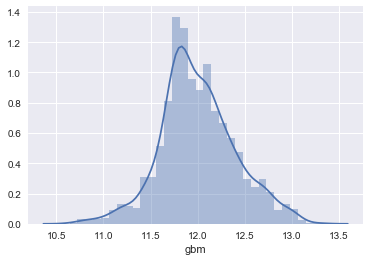

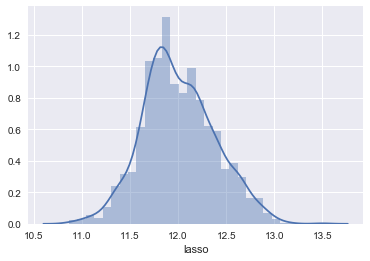

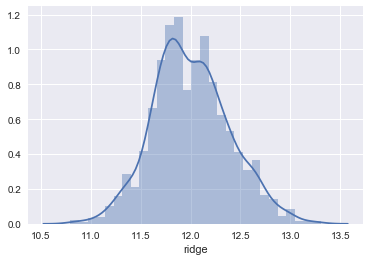

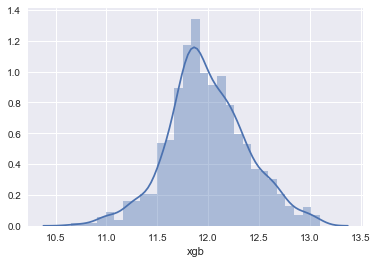

In [92]:
for i in df.iteritems():
    plt.figure()
    sns.distplot(i[1])

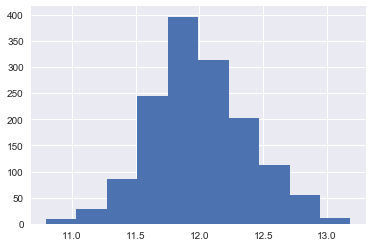

In [93]:
df.mean(axis=1).hist()

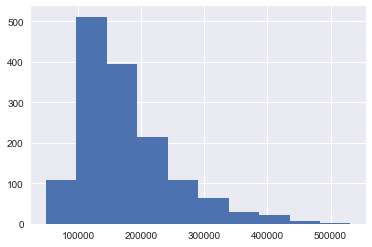

In [96]:
pred_te_y = pd.DataFrame({"Id": te_X.index, 
                          "SalePrice": df.mean(axis=1)})
pred_te_y.loc[pred_te_y.SalePrice < 10.2, "SalePrice"] = 10.2 
pred_te_y.loc[:, "SalePrice"] = pred_te_y.loc[:, "SalePrice"].apply(lambda x: np.e**x)

#save submission
pred_te_y.to_csv("submission/mix4_set1.csv", index=False)

pred_te_y.SalePrice.hist()